In [1]:
import pandas as pd
from ISLP import load_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.ensemble import (RandomForestClassifier as RFC,
                              GradientBoostingClassifier as GBC)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree,
                          export_text)

#load dataset
OJ = load_data('OJ')

Create a training set contain a random sample of 800 observations, and a test set containing the remaining observations. You will also need to convert the Store7 column to numeric.

In [2]:
OJ['Store7'] = OJ['Store7'].map({'Yes': 1, 'No': 0})


train, test = train_test_split(OJ, train_size=800, random_state=42)

#Convert Store7 to numeric (in case it’s read as string or object)
OJ['Store7'] = pd.to_numeric(OJ['Store7'], errors='coerce')


# Split data into features (X) and target (y) for training and testing
y_train = train['Purchase']
X_train = train.drop('Purchase', axis=1)
y_test = test['Purchase']
X_test = test.drop('Purchase', axis=1)

Fit a single tree to the training data, with Purchase as the response and the other variables as predictors. Use 6 as the maximum number of leaf nodes. Produce a confusion matrix and state the total misclassification error on training data.

In [3]:
# Initialize Decision Tree Classifier with up to 6 leaf nodes
tree1 = DTC(max_leaf_nodes=6, random_state=2)

# Fit the model on training data
tree1.fit(X_train, y_train)

# Predict on training set
pred_train = tree1.predict(X_train)

# Compute confusion matrix and training error
conf_train = confusion_matrix(y_train, pred_train)
train_error = 1 - accuracy_score(y_train, pred_train)

print("Training confusion matrix")
print(conf_train)
print(f'Training error: {train_error:.4f}')

Training confusion matrix
[[451  43]
 [ 82 224]]
Training error: 0.1562


Use cross-validation to determine the optimal number of leaf nodes

In [4]:
from sklearn.model_selection import cross_validate

# Range of possible leaf node counts to test
leaf_sizes = range(2,21)

cv_scores = []

# Perform cross-validation for each leaf size
for size in leaf_sizes:
    model = DTC(max_leaf_nodes=size, random_state=2)
    scores = cross_validate(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores['test_score'])
    cv_scores.append(mean_score)
    print(f"max_leaf_nodes={size}: mean CV accuracy = {mean_score:.5f}")

# Find the best number of leaf nodes
best_size = leaf_sizes[np.argmax(cv_scores)]
print(f"\nBest number of leaf nodes: {best_size}")

# Train final model with this optimal size
final_model = DTC(max_leaf_nodes=best_size, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate on test data
y_pred = final_model.predict(X_test)
test_error = 1 - accuracy_score(y_test, y_pred)

print(f"Test misclassification error (best model): {test_error:.4f}")

max_leaf_nodes=2: mean CV accuracy = 0.79625
max_leaf_nodes=3: mean CV accuracy = 0.79625
max_leaf_nodes=4: mean CV accuracy = 0.81125
max_leaf_nodes=5: mean CV accuracy = 0.82625
max_leaf_nodes=6: mean CV accuracy = 0.83000
max_leaf_nodes=7: mean CV accuracy = 0.83125
max_leaf_nodes=8: mean CV accuracy = 0.83500
max_leaf_nodes=9: mean CV accuracy = 0.83500
max_leaf_nodes=10: mean CV accuracy = 0.83125
max_leaf_nodes=11: mean CV accuracy = 0.83000
max_leaf_nodes=12: mean CV accuracy = 0.83000
max_leaf_nodes=13: mean CV accuracy = 0.83500
max_leaf_nodes=14: mean CV accuracy = 0.83250
max_leaf_nodes=15: mean CV accuracy = 0.83250
max_leaf_nodes=16: mean CV accuracy = 0.83250
max_leaf_nodes=17: mean CV accuracy = 0.82750
max_leaf_nodes=18: mean CV accuracy = 0.82750
max_leaf_nodes=19: mean CV accuracy = 0.82875
max_leaf_nodes=20: mean CV accuracy = 0.83125

Best number of leaf nodes: 13
Test misclassification error (best model): 0.2444


Create a plot of the tree

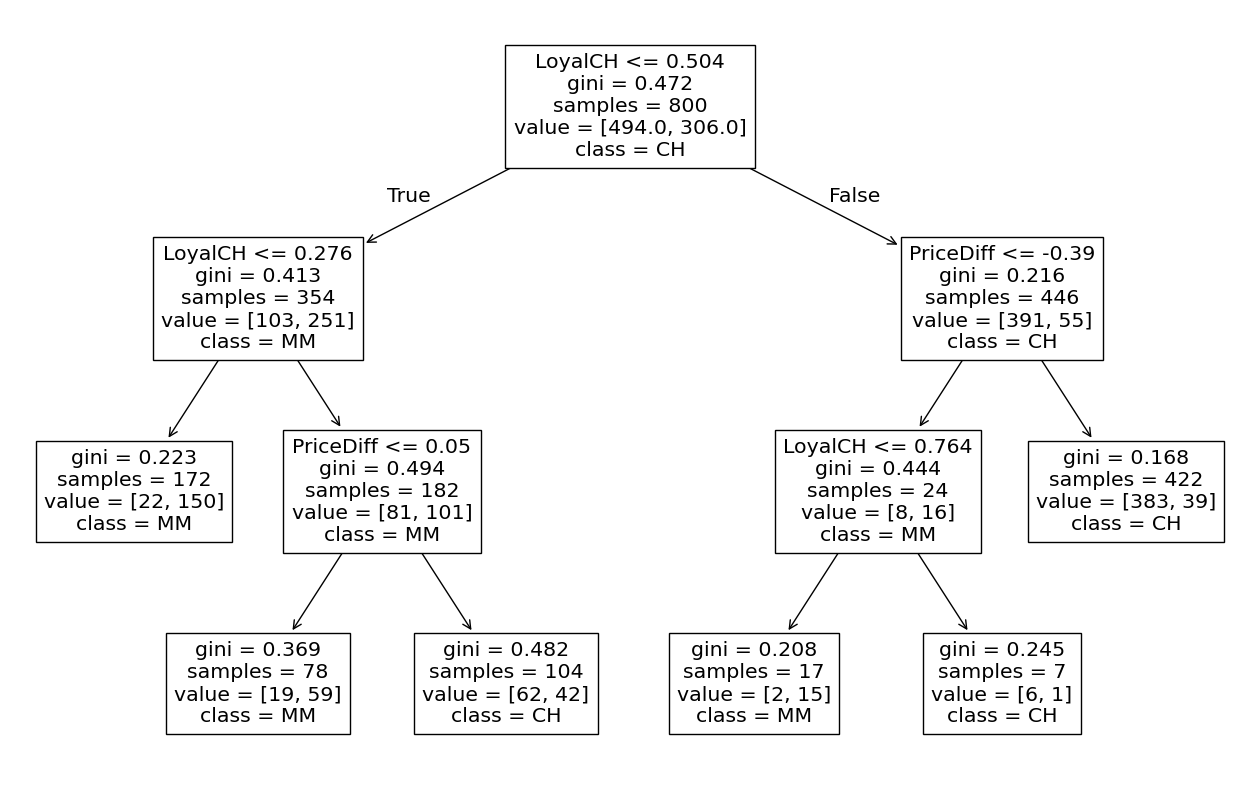

In [5]:
plt.figure(figsize=(16,10))
plot_tree(tree1, feature_names=X_train.columns, class_names=['CH', 'MM'])
plt.show()

Create a random forest model to predict Purchase. Iterate on your random forest model to search for optimal hyperparameters.

In [6]:
import warnings

warnings.filterwarnings("ignore") 

rf = RFC(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 200],         # number of trees
    'max_depth': [None, 5, 10, 20],        # maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # minimum samples per leaf
    'max_features': ['auto', 'sqrt', 'log2']  # number of features to consider at each split
}

# Grid search
grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:")
for param, value in grid.best_params_.items():
    print(f"{param}: {value}")

best_rf = grid.best_estimator_

Best hyperparameters:
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 10
n_estimators: 100


Construct a lift chart for your final random forest model on test data.

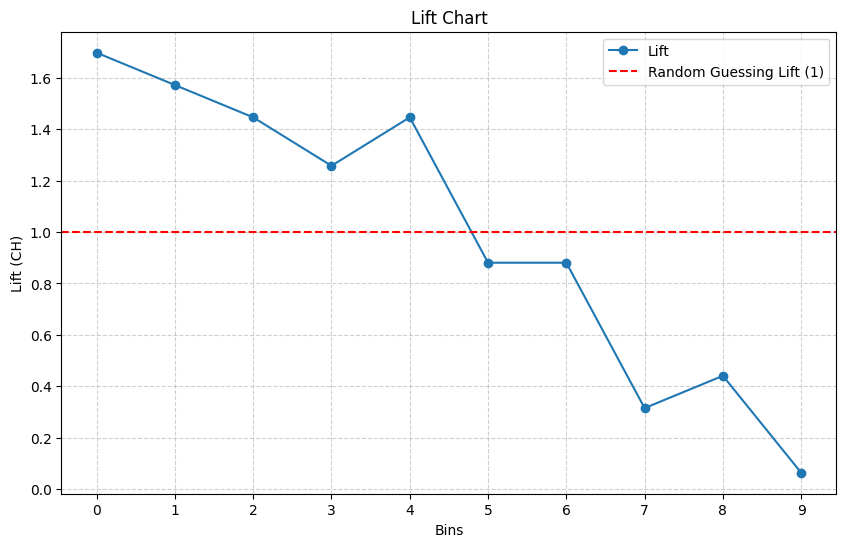

In [7]:
def plot_lift_chart(y_true, y_preds, n_bins=10):
    
    data = pd.DataFrame({'y_true': y_true, 'y_preds': y_preds})

    data = data.sort_values(by='y_preds', ascending=False)
    data['bin'] = pd.qcut(data['y_preds'], n_bins, labels=False)

        # Use top class as reference
    top_class = data['y_true'].value_counts().idxmax()

    lift_data = data.groupby('bin').agg(
        total_count=('y_true', 'count'),
        actual_top_class_count=('y_true', lambda x: (x == top_class).sum())
    ).reset_index()

    expected_rate = (data['y_true'] == top_class).mean()
    lift_data['lift'] = (lift_data['actual_top_class_count'] / lift_data['total_count']) / expected_rate
    y_label = f'Lift ({top_class})'
# Plot
    plt.figure(figsize=(10, 6))
    plt.plot(lift_data['bin'], lift_data['lift'], marker='o', label='Lift')
    plt.axhline(y=1, color='r', linestyle='--', label='Random Guessing Lift (1)')
    plt.title('Lift Chart')
    plt.xlabel('Bins')
    plt.ylabel(y_label)
    plt.xticks(lift_data['bin'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  
plot_lift_chart(y_test, y_pred_proba, n_bins=10)

Create a gradient boosting model to predict Purchase. Iterate on your gradient boosting model to search for optimal hyperparameters.

In [8]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

gbm = GBC(random_state=2)

# Grid search with 5-fold CV
grid = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_gbm = grid.best_estimator_

print("Best hyperparameters:")
for param, value in grid.best_params_.items():
    print(f"{param}: {value}")

Best hyperparameters:
learning_rate: 0.05
max_depth: 3
n_estimators: 100


Construct a dual lift chart which compares your best random forest model to your best gradient boosting model.

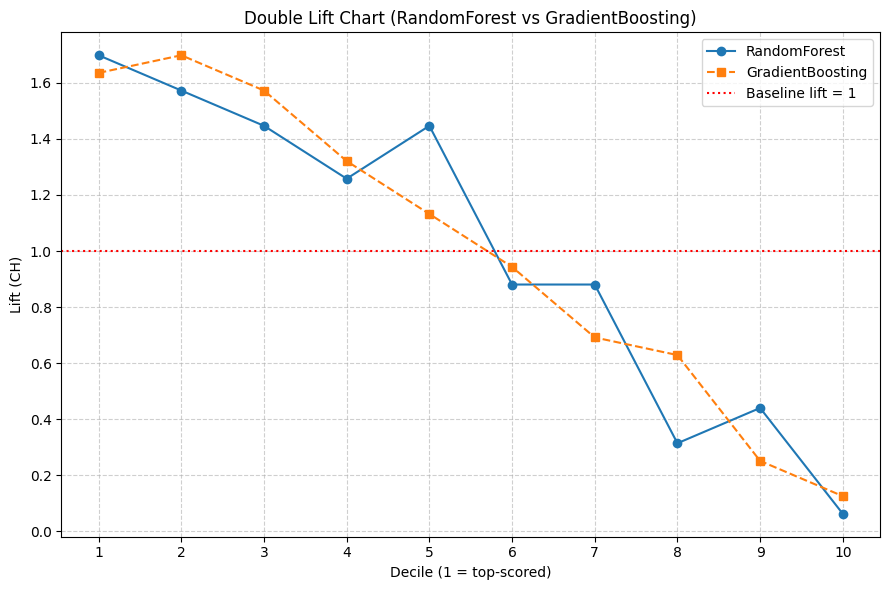

In [11]:
# --- Double Lift Chart: simple final version ---
%matplotlib inline

def _lift_by_decile(y_true, y_score, n_bins=10, pos_label=None):
    y = pd.Series(y_true)
    if pos_label is None:
       vc = y.value_counts()
       pos_label = vc.idxmin() if len(vc) == 2 else vc.index[0] 

    y_bin = (y == pos_label).astype(int)
    df = pd.DataFrame({"y": y_bin, "score": y_score})  

    # High scores first; 1 = top decile
    ranks = df["score"].rank(method="first", ascending=False)
    df["bin"] = pd.qcut(ranks, q=n_bins, labels=range(1, n_bins+1)) 

    base_rate = df["y"].mean()
    tab = (
    df.groupby("bin", observed=True)
    .agg(count=("y", "size"), positives=("y", "sum"))
    .reset_index()
    )
    tab["rate"] = tab["positives"] / tab["count"]
    tab["lift"] = tab["rate"] / base_rate
    return tab, pos_label

def plot_double_lift_chart(
 y_true, score1, score2,
 model1_name="Model A", model2_name="Model B",
 n_bins=10, pos_label=None
):
    tab1, pos = _lift_by_decile(y_true, score1, n_bins=n_bins, pos_label=pos_label)
    tab2, _ = _lift_by_decile(y_true, score2, n_bins=n_bins, pos_label=pos) 

    x = tab1["bin"].astype(int)

    plt.figure(figsize=(9,6))
    plt.plot(x, tab1["lift"].values, marker="o", label=f"{model1_name}")
    plt.plot(x, tab2["lift"].values, marker="s", linestyle="--", label=f"{model2_name}")
    plt.axhline(1.0, linestyle=":", color="red", label="Baseline lift = 1")
    plt.title(f"Double Lift Chart ({model1_name} vs {model2_name})")
    plt.xlabel("Decile (1 = top-scored)")
    plt.ylabel(f"Lift ({pos})")
    plt.xticks(range(1, n_bins+1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    #filename = f"double_lift_{model1_name}_vs_{model2_name}.png".replace(" ", "_")
    #plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    return None

# ---------- Run it ----------

best_rf.fit(X_train, y_train)
best_gbm.fit(X_train, y_train)

POS = "CH"
rf_col = list(best_rf.classes_).index(POS)
gbm_col = list(best_gbm.classes_).index(POS)

rf_score = best_rf.predict_proba(X_test)[:, rf_col]
gbm_score = best_gbm.predict_proba(X_test)[:, gbm_col]

plot_double_lift_chart(
 y_test, rf_score, gbm_score,
 model1_name="RandomForest", model2_name="GradientBoosting",
 n_bins=10, pos_label=POS
)